In [1]:
pip install duckdb 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


# LOADING DATASET

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import duckdb as ddb   

# Load data
menu = pd.read_csv('../Data/manu_FC.csv')
orders = pd.read_csv('../Data/selling_transactions.csv')
inventory = pd.read_csv('../Data/inventory_waste.csv')
recipes = pd.read_csv('../Data/recipes.csv')

# Display EDA results
print("Menu DF:")
display(menu.head())
print("Orders DF:")
display(orders.head())
print("Inventory DF:")
display(inventory.head())
print("Recipes DF:")
display(recipes.head())

Menu DF:


,item_id,item_name,category,theoretical_cost,target_margin,is_active
0,ANT-001,Bruschetta al pomodoro,Antipasti,1.8,74,True
1,ANT-002,Caprese,Antipasti,2.5,72,True
2,ANT-003,Prosciutto e melone,Antipasti,3.2,71,True
3,ANT-004,Affettati misti,Antipasti,4.0,69,True
4,PIZ-001,Margherita,Pizze,2.1,77,True


Orders DF:


,transaction_id,timestamp,store_id,item_id,channel,qty,total_net_price
0,TXN-000001,2024-01-01 20:22:00,MIL-01,PIZ-002,Glovo,2,16.0
1,TXN-000002,2024-01-01 13:52:00,MIL-01,BEV-005,Sala,2,3.0
2,TXN-000003,2024-01-01 21:54:00,MIL-01,PRI-003,Deliveroo,2,26.0
3,TXN-000004,2024-01-01 20:51:00,MIL-01,SEC-005,Take-away,2,32.0
4,TXN-000005,2024-01-01 13:02:00,MIL-01,PIZ-007,Deliveroo,1,15.0


Inventory DF:


,date,store_id,item_id,ingredient_name,waste_type,waste_qty,waste_value
0,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Scaduto,0.98,0.78
1,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Sfrido,1.33,1.06
2,2024-01-01,MIL-01,VER-01,Verdure miste (kg),Deteriorato,1.30,4.55
3,2024-01-01,MIL-02,PRO-01,Prosciutto crudo (kg),Errore Comanda,1.92,42.24
4,2024-01-01,MIL-02,VER-01,Verdure miste (kg),Sfrido,1.85,6.48


Recipes DF:


,dish_id,dish_name,ingredient_id,ingredient_name,quantity,unit,costo_unitario,costo_ingrediente
0,ANT-001,Bruschetta al pomodoro,TOM-01,Pomodoro pelato,0.080,kg,1.2,0.10
1,ANT-001,Bruschetta al pomodoro,OLI-01,Olio EVO,0.015,lt,5.0,0.07
2,ANT-001,Bruschetta al pomodoro,BAS-01,Basilico,0.300,mazzo,1.5,0.45
3,ANT-002,Caprese,MOZZ-01,Mozzarella fior di latte,0.125,kg,5.5,0.69
4,ANT-002,Caprese,TOM-01,Pomodoro pelato,0.150,kg,1.2,0.18


### Prossima tabella transazioni (orders) aggiungere numero coperti

### DATA AUGMENTATION

In [4]:
def inject_realism_full(sales_df, inventory_df, menu_df):
    print("--- 🌪️ AVVIO SIMULAZIONE REALISTICA: FULL MENU ---")
    
    # Lavoriamo su copie per non sporcare i dataframe originali se rieseguiamo la cella più volte
    sales_df = sales_df.copy()
    inventory_df = inventory_df.copy()
    
    # --- 1. CONFIGURAZIONE SCENARIO ---
    
    sales_scenario = {
        'Acqua naturale':       {'qty': 4.0, 'price': 1.0},
        'Caffè':                {'qty': 3.5, 'price': 1.0},
        'Spritz':               {'qty': 2.0, 'price': 1.2},
        'Vino rosso (calice)':  {'qty': 1.5, 'price': 1.1},
        'Birra media':          {'qty': 2.5, 'price': 1.0},
        'Margherita':           {'qty': 3.0, 'price': 1.0},
        'Diavola':              {'qty': 0.6, 'price': 1.0},
        'Marinara':             {'qty': 0.2, 'price': 1.0},
        'Pizza gourmet tartufo':{'qty': 0.4, 'price': 1.5},
        'Bufala e pachino':     {'qty': 1.2, 'price': 1.2},
        'Carbonara':            {'qty': 2.2, 'price': 1.0},
        'Amatriciana':          {'qty': 1.8, 'price': 1.0},
        'Cacio e pepe':         {'qty': 1.5, 'price': 1.1},
        'Branzino al forno':    {'qty': 0.8, 'price': 1.3},
        'Tagliata di manzo':    {'qty': 0.7, 'price': 1.4},
        'Cotoletta alla milanese': {'qty': 1.5, 'price': 1.1},
        'Tiramisù':             {'qty': 2.0, 'price': 1.0},
        'Panna cotta':          {'qty': 0.5, 'price': 1.0},
    }

    waste_scenario = {
        'Mozzarella (kg)':          3.5,
        'Pesce branzino (kg)':      4.0,
        'Verdure miste (kg)':       2.5,
        'Prosciutto crudo (kg)':    1.5,
        'Carne manzo (kg)':         1.2,
        'Salame piccante (kg)':     1.8,
        'Funghi porcini (kg)':      1.3,
        'Farina tipo 00 (kg)':      0.2,
        'Olio EVO (lt)':            0.1,
        'Pomodoro San Marzano (kg)':0.3,
    }

    # --- 2. APPLICAZIONE LOGICA SALES ---
    sales_df['unit_price_temp'] = sales_df['total_net_price'] / sales_df['qty']
    
    for item_name, multipliers in sales_scenario.items():
        try:
            target_ids = menu_df.loc[menu_df['item_name'] == item_name, 'item_id'].values
            if len(target_ids) > 0:
                t_id = target_ids[0]
                mask = sales_df['item_id'] == t_id
                
                if mask.any():
                    sales_df.loc[mask, 'qty'] *= multipliers['qty']
                    new_price = sales_df.loc[mask, 'unit_price_temp'] * multipliers['price']
                    sales_df.loc[mask, 'total_net_price'] = sales_df.loc[mask, 'qty'] * new_price
        except Exception as e:
            print(f"Skipping {item_name}: {e}")

    sales_df.drop(columns=['unit_price_temp'], inplace=True)

    # --- 3. APPLICAZIONE LOGICA WASTE ---
    # Logica euristica: cerchiamo corrispondenze parziali nei nomi degli ingredienti
    # (Metodo robusto che funziona anche se non hai gli ID precisi nel dizionario)
    
    # Prima aggiungiamo rumore casuale
    inventory_df['waste_qty'] *= 1.0 # (O usa np.random se vuoi)

    # Mapping avanzato: Cerchiamo di applicare i moltiplicatori cercando il nome ingrediente
    # Se il tuo inventory ha una colonna 'item_name' o 'description', usala.
    # Qui assumo che inventory abbia gli ID, ma provo a fare il match tramite il dizionario waste_scenario
    
    # Se inventory ha 'ingredient_name', usiamo quello. Altrimenti saltiamo ai codici noti.
    # CODICI NOTI (Hardcoded per sicurezza basati sui tuoi dati precedenti)
    known_mapping = {
        'MOZZ-01': 3.5, # Mozzarella
        'PES-01':  4.0, # Branzino
        'FAR-01':  0.2, # Farina
        'SAL-01':  1.8, # Salame
        'OLI-01':  0.1, # Olio
        'TOM-01':  0.3, # Pomodoro
        'FUN-01':  1.3  # Funghi
    }
    
    for ing_id, mult in known_mapping.items():
        # Cerca nella colonna item_id (o ingredient_id a seconda del tuo df)
        col_name = 'ingredient_id' if 'ingredient_id' in inventory_df.columns else 'item_id'
        mask = inventory_df[col_name] == ing_id
        
        if mask.any():
            inventory_df.loc[mask, 'waste_qty'] *= mult
            inventory_df.loc[mask, 'waste_value'] *= mult

    print("✅ Dati sbilanciati correttamente!")
    
    return sales_df, inventory_df

orders, inventory = inject_realism_full(orders, inventory, menu)

--- 🌪️ AVVIO SIMULAZIONE REALISTICA: FULL MENU ---
✅ Dati sbilanciati correttamente!


/var/folders/rw/gn7kmssn2p7gjvsj5rblz4sh0000gn/T/ipykernel_51861/1431228716.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.  7.  7.  ... 7.  7.  3.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sales_df.loc[mask, 'qty'] *= multipliers['qty']


# PRIMO PILASTRO - PROFITABILITY

In [5]:
# PROFITABILITY ANALYSIS PIPELINE

# --- FASE 1: ANALISI INGREDIENTE (Il "Backend" della cucina) ---

# 1.
# Calcolo Costo Unitario Medio e Totale Spreco per ingrediente
# Costo Unitario Stimato = Valore Spreco / Quantità Sprec
# IN QUESTO CASO SI FA REVERSE ENGINEERING DEL LISTINO PREZZO. VALUTO QUANTO MI COSTA REALMENTE UN INGREDIENTE IN BASE A QUANTO SPRECO
# In un sistema aziendale maturo, questo passaggio verrebbe sostituito da un LEFT JOIN con la tabella pricelist_fornitori
inventory['unit_cost_est'] = inventory['waste_value'] / inventory['waste_qty']
ing_stats = inventory.groupby('item_id').agg({
    'unit_cost_est': 'mean',    # Costo medio al Kg
    'waste_qty': 'sum'          # Totale KG buttati
}).reset_index().rename(columns={'item_id': 'ingredient_id', 'waste_qty': 'waste_kg_total'})

# 2.
# Calcolo Consumo Teorico Totale (Quanto avremmo dovuto usare, senza considerare sprechi)
sales_exploded = pd.merge(orders, recipes, left_on='item_id', right_on='dish_id')
sales_exploded['theo_qty'] = sales_exploded['qty'] * sales_exploded['quantity'] # qty = numero piatti venduti, quantity = quantità ingrediente per piatto
theo_stats = sales_exploded.groupby('ingredient_id')['theo_qty'].sum().reset_index()

# 3.
# Unione: Creazione del Fattore di Inefficienza (K)
# Il Fattore K (o coefficiente di inefficienza): 
# è la percentuale che aggiungi al Food Cost teorico per coprire tutto ciò che "scompare" tra l'acquisto della merce e la vendita del piatto.
# RistoratoreTop lo definisce spesso come il "coefficiente di correzione" necessario per rendere reale una ricetta teorica.
k_df = pd.merge(theo_stats, ing_stats, on='ingredient_id', how='left').fillna(0)

# K = (Teorico + Spreco) / Teorico
# Esempio: Se per fare i piatti servivano 10kg, ma ne ho buttati 2kg, ne ho comprati 12.
# Il costo reale è il 20% in più. K = 1.2
k_df['k_factor'] = np.where(k_df['theo_qty'] > 0, 
                           (k_df['theo_qty'] + k_df['waste_kg_total']) / k_df['theo_qty'], 1) # Evitiamo divisioni per zero, assumiamo K=1 se non ci sono vendite (es. zafferano in stock ma non in ricette) evitando DivisionZeroError
                            # implementare inv_loss:
                            # Consunmo Reale = (Giacenza Iniziale + Acquisti) - Giacenza Finale
                            # inv_loss = Consumo Reale - Consumo Teorico (da ricette/vendite)
                            
                            
# --- FASE 2: ANALISI PIATTO (Il "Frontend" del menu) ---

# 4.
# Applichiamo il K-Factor alla ricetta: Prende il vecchio ricettario cartaceo e ci scrive sopra i nuovi prezzi "maggiorati".
# Ogni ingrediente ora costa: (Quantità * Costo Unitario) * K
recipes_real = pd.merge(recipes, k_df[['ingredient_id', 'unit_cost_est', 'k_factor']], on='ingredient_id', how='left')

# Costo Teorico (Standard) vs Costo Reale (Con sprechi)
# calcolo prima il costo teorico: quanto dovrebbe costare un singolo piatto se non ci fossero sprechi
recipes_real['cost_theo'] = recipes_real['quantity'] * recipes_real['unit_cost_est']
# aggiungo il k_factor per ottenere il costo reale: quanto ti costa veramente quel piatto, caricandoci sopra anche la "tassa" dello spreco che hai rilevato in magazzino.
recipes_real['cost_real'] = recipes_real['cost_theo'] * recipes_real['k_factor']

# 5.
# Sommiamo gli ingredienti per ottenere il costo del PIATTO
dish_costs = recipes_real.groupby('dish_id').agg({
    'cost_theo': 'sum',
    'cost_real': 'sum'
}).reset_index()

# --- FASE 3: IL VERDETTO (Confronto col Menu) ---

# 6.
# Prezzo medio di vendita effettivo (al netto di sconti): total_net_price (soldi veri incassati) e lo divide per i piatti venduti. È il "Prezzo Medio Scontrino".
avg_sales = orders.groupby('item_id').agg({'total_net_price': 'sum', 'qty': 'sum'}).reset_index()
avg_sales['real_price'] = avg_sales['total_net_price'] / avg_sales['qty'] # Calcola a quanto vendiamo davvero i piatti.

# 7.
# Tabella Finale
final_report = pd.merge(dish_costs, avg_sales[['item_id', 'real_price', 'qty']], left_on='dish_id', right_on='item_id').rename(columns={'qty': 'sold_qty'})
final_report = pd.merge(final_report, menu[['item_id', 'item_name', 'category']], on='item_id')

# Calcolo Margine di Contribuzione
# Questi sono i soldi che ti rimangono in tasca per pagare l'affitto, la luce e il tuo stipendio. È il Margine di Contribuzione: in € e in %
final_report['margin_real_€'] = final_report['real_price'] - final_report['cost_real']
final_report['margin_pct'] = (final_report['margin_real_€'] / final_report['real_price']) * 100

# Ordiniamo per i piatti più critici (quelli dove perdiamo soldi o guadagniamo poco)
display(final_report[['category', 'item_name', 'real_price', 'cost_theo', 'cost_real', 'sold_qty', 'margin_pct', 'margin_real_€']].sort_values('margin_real_€', ascending=False).round(2))

# 7.1. Identifica i piatti che hanno Costo Teorico = 0 (Sospetti)
ghost_dishes = final_report[final_report['cost_theo'] == 0]

print(f"Ci sono {len(ghost_dishes)} piatti senza ricetta o costo:")
display(ghost_dishes[['item_name', 'sold_qty', 'real_price', 'cost_theo', 'margin_pct']])

# 7.2. Soluzione Rapida per l'Analisi
# Filtriamo via questi piatti dal grafico finale per non falsare la matrice
final_report_clean = final_report[final_report['cost_theo'] > 0].copy() # Senza il copy() non crea una nuova tabella fisica, ma crea solo una "finestra" (View) sulla tabella originale.
                                                                        # Quindi ogni modifica fatta a final_report_clean si riflette anche in final_report, causando warning e potenziali errori.

print(f"\nReport pulito: rimosse {len(ghost_dishes)} righe. Procediamo con l'analisi.")

# 8. Visualizzazione Matrice Profitabilità

,category,item_name,real_price,cost_theo,cost_real,sold_qty,margin_pct,margin_real_€
18,Pizze,Pizza gourmet tartufo,33.0,0.50,0.52,2647.6,98.44,32.48
26,Secondi,Tagliata di manzo,33.6,6.72,9.72,4587.8,71.08,23.88
28,Secondi,Cotoletta alla milanese,22.0,0.00,0.00,9903.0,100.00,22.00
27,Secondi,Ossobuco alla milanese,22.0,0.58,0.71,6604.0,96.78,21.29
25,Primi,Risotto ai funghi porcini,18.0,0.00,0.00,6309.0,100.00,18.00
16,Pizze,Bufala e pachino,18.0,0.92,0.95,7742.4,94.72,17.05
30,Secondi,Pollo arrosto,16.0,0.24,0.25,6606.0,98.44,15.75
23,Primi,Spaghetti alle vongole,16.0,0.36,0.37,6341.0,97.66,15.63
24,Primi,Risotto alla milanese,15.0,0.00,0.00,6552.0,100.00,15.00
21,Primi,Cacio e pepe,14.3,0.00,0.00,9793.5,100.00,14.30


Ci sono 8 piatti senza ricetta o costo:


,item_name,sold_qty,real_price,cost_theo,margin_pct
7,Tiramisù,12674.0,7.0,0.0,100.0
8,Panna cotta,3189.0,6.0,0.0,100.0
9,Cheesecake,6450.0,8.0,0.0,100.0
19,Carbonara,14405.6,14.0,0.0,100.0
21,Cacio e pepe,9793.5,14.3,0.0,100.0
24,Risotto alla milanese,6552.0,15.0,0.0,100.0
25,Risotto ai funghi porcini,6309.0,18.0,0.0,100.0
28,Cotoletta alla milanese,9903.0,22.0,0.0,100.0



Report pulito: rimosse 8 righe. Procediamo con l'analisi.


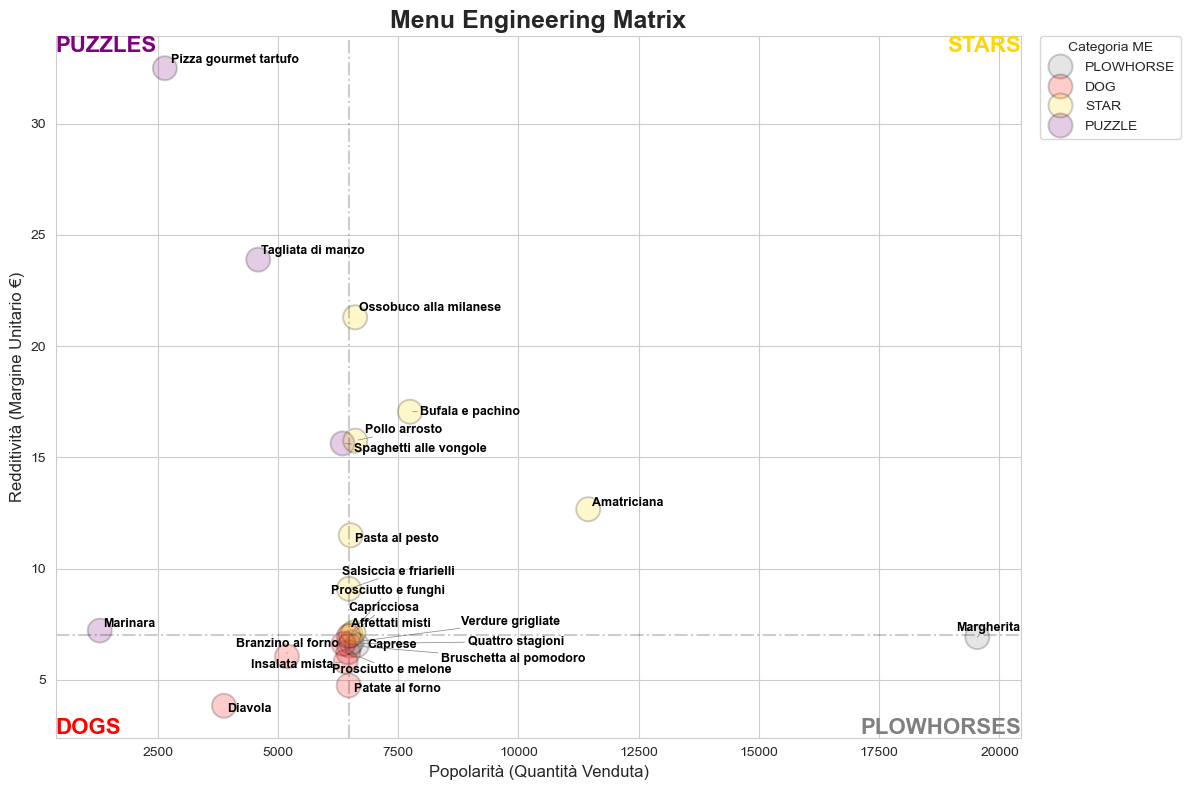

In [6]:

def create_menu_matrix(df, x_col='sold_qty', y_col='margin_real_€', label_col='item_name', title="Menu Engineering Matrix"):
    """
    Generate a professional Engineering Menu matrix.
    
    Args:
        df: The dataframe containing the data.
        x_col: Column name Popularity (e.g. 'qty').
        y_col: Profitability column name (e.g. 'margin_real_€').
        label_col: Name of the column with the names of the dishes.

    Requirements:
        - matplotlib
        - seaborn
        - adjustText (optional, for better label management)
    """

    # 1. importing adjustText to handle labels
    try:
        from adjustText import adjust_text
        HAS_ADJUST_TEXT = True
    except ImportError:
        HAS_ADJUST_TEXT = False
        
    
    # 2. Calculating Medians (the boundaries of the quadrants)
    median_x = df[x_col].median()
    median_y = df[y_col].median()

    # 3. Assigning the category to each dish to color them
    def get_category(row):
        if row[x_col] >= median_x and row[y_col] >= median_y:
            return 'STAR'
        elif row[x_col] < median_x and row[y_col] >= median_y:
            return 'PUZZLE'
        elif row[x_col] >= median_x and row[y_col] < median_y:
            return 'PLOWHORSE'
        else:
            return 'DOG'

    df['me_category'] = df.apply(get_category, axis=1)
    
    # Setting color palette
    palette = {
        'STAR': 'gold',       
        'PUZZLE': 'purple',   
        'PLOWHORSE': 'gray',  
        'DOG': 'red'         
    }

    # 4. Graphic setup
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Main scatterplot 
    sns.scatterplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        hue='me_category',  
        palette=palette,
        s=300,              
        edgecolor='black',
        alpha=0.2
    )

    # 5. Drwawing quadrants lines
    plt.axvline(median_x, color='black', linestyle='-.', alpha=0.2)
    plt.axhline(median_y, color='black', linestyle='-.', alpha=0.2)
    
    # List where collecting all text objects
    texts = []
    
    # Loop over each row of the dataframe
    for i in range(df.shape[0]):
        # Creating text object but we don't print it permanently yet
        t = plt.text(
            x=df[x_col].iloc[i], 
            y=df[y_col].iloc[i], 
            s=df[label_col].iloc[i],
            fontsize=9, 
            weight='bold', 
            color='black'
        )
        texts.append(t) 
    
    # Applyiing adjust text
    if HAS_ADJUST_TEXT:
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # 6. FINAL FORMATTING ---
    # Quadrant Labels
    x_lims = plt.xlim()
    y_lims = plt.ylim()
    plt.text(x_lims[1], y_lims[1], 'STARS', ha='right', va='top', fontsize=16, color='gold', weight='heavy')
    plt.text(x_lims[0], y_lims[1], 'PUZZLES', ha='left', va='top', fontsize=16, color='purple', weight='heavy')
    plt.text(x_lims[1], y_lims[0], 'PLOWHORSES', ha='right', va='bottom', fontsize=16, color='gray', weight='heavy')
    plt.text(x_lims[0], y_lims[0], 'DOGS', ha='left', va='bottom', fontsize=16, color='red', weight='heavy')

    # Titles
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel('Popolarità (Quantità Venduta)', fontsize=12)
    plt.ylabel('Redditività (Margine Unitario €)', fontsize=12)
    
    # Moving legend out the graph
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Categoria ME")
    
    plt.tight_layout()
    plt.show()

# Plotting the Menu Engineering Matrix
create_menu_matrix(final_report_clean)

---------------------------------------------------------

----------------

# SECONDO PILASTRO - CROSS SELLING

#### DATA INJECTION

In [7]:
def inject_associations(sales_df, menu_df):
    print("--- 🔗 INIEZIONE ASSOCIAZIONI (Cross-Selling Didattico) ---")
    
    # 1. Definiamo le coppie che vogliamo forzare nella Heatmap
    # (Trigger Item) -> (Target Item che aggiungiamo noi)
    combos = [
        # COMBO SALVA-DIAVOLA: Chi prende la Diavola beve Birra (per spegnere il piccante)
        {'trigger': 'Diavola', 'target': 'Birra media', 'prob': 0.85}, 
        
        # COMBO CLASSICA: Chi prende il Tiramisù prende il Caffè
        {'trigger': 'Tiramisù', 'target': 'Caffè', 'prob': 0.90},
        
        # COMBO APERITIVO: Chi prende lo Spritz ordina Patatine (o Verdure grigliate se non hai patatine)
        {'trigger': 'Spritz', 'target': 'Verdure grigliate', 'prob': 0.70},
        
        # COMBO ROMANA: Carbonara chiama Vino Rosso
        {'trigger': 'Carbonara', 'target': 'Vino rosso (calice)', 'prob': 0.80}
    ]
    
    new_rows = []
    
    # Cicliamo sulle regole
    for combo in combos:
        trigger_name = combo['trigger']
        target_name = combo['target']
        probability = combo['prob']
        
        # Troviamo gli ID
        try:
            trigger_id = menu_df.loc[menu_df['item_name'] == trigger_name, 'item_id'].values[0]
            target_id = menu_df.loc[menu_df['item_name'] == target_name, 'item_id'].values[0]
        except IndexError:
            print(f"Skipping combo {trigger_name}+{target_name}: ID non trovato.")
            continue
            
        # Troviamo tutti gli scontrini (transaction_id) che contengono il TRIGGER
        trigger_transactions = sales_df.loc[sales_df['item_id'] == trigger_id, 'transaction_id'].unique()
        
        print(f"Trovati {len(trigger_transactions)} scontrini con {trigger_name}. Inietto {target_name}...")
        
        # Per ogni scontrino, decidiamo se aggiungere il TARGET
        count_added = 0
        for t_id in trigger_transactions:
            # Tiriamo un dado (random) in base alla probabilità
            if np.random.rand() < probability:
                # Controllo se c'è già per non duplicare
                existing_items = sales_df.loc[sales_df['transaction_id'] == t_id, 'item_id'].values
                
                if target_id not in existing_items:
                    # Creiamo la riga falsa
                    new_row = {
                        'transaction_id': t_id,
                        'item_id': target_id,
                        'qty': 1.0, # Ne aggiungiamo 1
                        'total_net_price': 5.0, # Prezzo fittizio (non importa per la heatmap, ma serve per coerenza)
                        'item_name': target_name # Se hai la colonna item_name nel sales
                    }
                    new_rows.append(new_row)
                    count_added += 1
        
        print(f" -> Aggiunte {count_added} righe di {target_name}.")

    # Uniamo le nuove righe al dataframe originale
    if len(new_rows) > 0:
        new_df = pd.DataFrame(new_rows)
        # Concateniamo
        sales_df = pd.concat([sales_df, new_df], ignore_index=True)
    
    print("--- ASSOCIAZIONI INIETTATE CON SUCCESSO ---")
    return sales_df

# --- ESECUZIONE ---
# Prima lanci inject_realism_full (per i volumi)
# Poi lanci questa (per le associazioni)
orders_c = orders.copy()
orders_c = inject_associations(orders_c, menu)

--- 🔗 INIEZIONE ASSOCIAZIONI (Cross-Selling Didattico) ---
Trovati 4292 scontrini con Diavola. Inietto Birra media...
 -> Aggiunte 3652 righe di Birra media.
Trovati 4210 scontrini con Tiramisù. Inietto Caffè...
 -> Aggiunte 3755 righe di Caffè.
Trovati 4241 scontrini con Spritz. Inietto Verdure grigliate...
 -> Aggiunte 3027 righe di Verdure grigliate.
Trovati 4336 scontrini con Carbonara. Inietto Vino rosso (calice)...
 -> Aggiunte 3421 righe di Vino rosso (calice).
--- ASSOCIAZIONI INIETTATE CON SUCCESSO ---


/var/folders/rw/gn7kmssn2p7gjvsj5rblz4sh0000gn/T/ipykernel_51861/3168612372.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x:1 if x > 0 else 0)


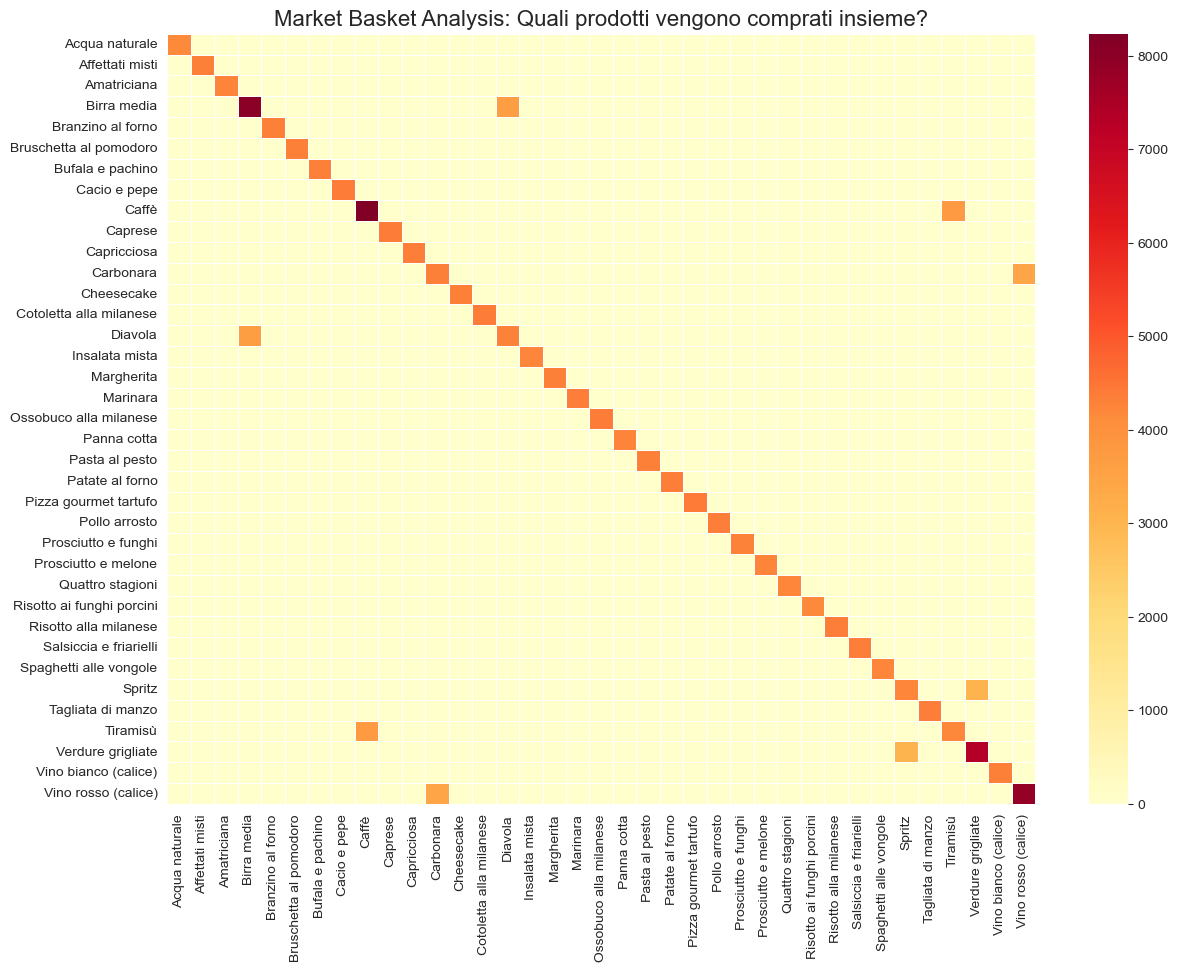


--- I MIGLIORI AMICI DELLA CARBONARA ---
item_name
Vino rosso (calice)          3421
Risotto ai funghi porcini       0
Patate al forno                 0
Pizza gourmet tartufo           0
Pollo arrosto                   0
Name: Carbonara, dtype: int64


In [8]:
# 1. PREPARAZIONE DATI
# grouping ordered dishes by transaction count
joined_tables = pd.merge(orders_c, menu[['item_id', 'item_name']], on='item_id', how='left').rename(columns={'item_name_y': 'item_name'}).drop(columns=['item_name_x'])
orders_filtered = joined_tables[['transaction_id', 'item_id', 'item_name', 'qty']].copy() #(senza copy) Spesso Pandas non crea una nuova tabella. Per risparmiare memoria, crea solo una "Vista" (View).
orders_filtered = orders_filtered[['transaction_id', 'item_id','item_name', 'qty']]

# 2. CREAZIONE DELLA "BASKET MATRIX" (One-Hot Encoding)
basket = orders_filtered.groupby(['transaction_id', 'item_name'])['qty'].sum().unstack().fillna(0)

# Convertiamo tutto in 1 (presenza) o 0 (assenza), non ci interessa se ne ha prese 3, ci basta che l'abbia presa.
basket = basket.applymap(lambda x:1 if x > 0 else 0)

# 3. MATRICE DI CO-OCCORRENZA (Chi compare con chi?)
# Algebra lineare: Matrice Trasposta * Matrice Originale
cooccurrence_matrix = basket.T.dot(basket) # L'operazione A.T.dot(A) (Trasposta per Originale) è il prodotto incrociato per trovare le intersezioni.
# La somma finale è letteralmente il conteggio delle volte che i due prodotti erano presenti contemporaneamente nello stesso scontrino.
# Diagonale: Quante volte è stato venduto quel piatto da solo (o in generale)
# Incroci: Quante volte sono stati venduti INSIEME

# 4. VISUALIZZAZIONE (HEATMAP)
plt.figure(figsize=(14, 10))
sns.heatmap(
    cooccurrence_matrix, 
    annot=False,       # Metti True se vuoi vedere i numeri (può essere disordinato se hai tanti piatti)
    cmap="YlOrRd",     # Giallo (poco legati) -> Rosso (Legatissimi)
    linewidths=.5
)
plt.title('Market Basket Analysis: Quali prodotti vengono comprati insieme?', fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.show()

# 5. ESTRAZIONE DELLE REGOLE (Top Associazioni per la Diavola)
target_item = 'Carbonara' # Cambia questo col nome esatto del tuo DOG

if target_item in cooccurrence_matrix.columns:
    # Prendi la riga della Diavola e ordina per chi appare di più con lei
    associations = cooccurrence_matrix[target_item].sort_values(ascending=False).drop(target_item) # Rimuovi se stessa
    print(f"\n--- I MIGLIORI AMICI DELLA {target_item.upper()} ---")
    print(associations.head(5))
else:
    print(f"Attenzione: '{target_item}' non trovato nel menu.")


--------------

----------

# TERZO PILASTRO - TIME ANALYSIS

### DAYPARTING ANALYSIS

In [9]:
# Formatting timestamps in transactions
transactions = orders.copy()
transactions['time'] = pd.to_datetime(transactions['timestamp']).dt.time
transactions['date'] = pd.to_datetime(transactions['timestamp']).dt.date
transactions = transactions.drop(columns=['timestamp'])

# merging with menu table in order to have item names
transactions = pd.merge(transactions, menu[['item_id', 'item_name']], on='item_id', how='left')
transactions

,transaction_id,store_id,item_id,channel,qty,total_net_price,time,date,item_name
0,TXN-000001,MIL-01,PIZ-002,Glovo,0.4,3.20,20:22:00,2024-01-01,Marinara
1,TXN-000002,MIL-01,BEV-005,Sala,7.0,10.50,13:52:00,2024-01-01,Caffè
2,TXN-000003,MIL-01,PRI-003,Deliveroo,3.0,42.90,21:54:00,2024-01-01,Cacio e pepe
3,TXN-000004,MIL-01,SEC-005,Take-away,2.0,32.00,20:51:00,2024-01-01,Pollo arrosto
4,TXN-000005,MIL-01,PIZ-007,Deliveroo,1.2,21.60,13:02:00,2024-01-01,Bufala e pachino
...,...,...,...,...,...,...,...,...,...
159912,TXN-159913,MIL-10,PRI-003,Sala,3.0,42.90,14:21:00,2024-12-31,Cacio e pepe
159913,TXN-159914,MIL-10,DOL-001,Sala,2.0,14.00,22:57:00,2024-12-31,Tiramisù
159914,TXN-159915,MIL-10,PRI-005,Sala,1.0,16.00,22:08:00,2024-12-31,Spaghetti alle vongole
159915,TXN-159916,MIL-10,PRI-003,Take-away,1.5,21.45,13:15:00,2024-12-31,Cacio e pepe


In [10]:
# Creating new table with time slots and aggregating sales, using DuckDB
query = """select store_id, item_id, item_name, cast(sum(qty) as int) as total_sold, date, 
           case
                when time < '12:00:00' then 'Morning'
                when time >= '12:00:00' and time < '13:00:00' then 'Lunch 1'
                when time >= '13:00:00' and time < '15:00:00' then 'Lunch 2'
                when time >= '19:00:00' and time < '20:00:00' then 'Dinner 1'
                when time >= '20:00:00' and time < '22:00:00' then 'Dinner 2'
                else 'Night'
           end as time_slot
        from transactions
        group by 1,2,3,5,6,"""

# Converting to DataFrame
stats = ddb.query(query).to_df()
display(stats.head())

# Grouping by store, item, time_slot to get total sold for each time slot
stats_grouped = stats.groupby(['store_id', 'item_id', 'item_name', 'time_slot']).agg({'total_sold': 'sum'}).reset_index()

stats_grouped = stats_grouped[~stats_grouped['item_id'].str.contains('BEV')]

# 1. PREPARAZIONE DELLA MATRICE (Pivot)
# Trasformiamo la tabella da "Lunga" (tante righe) a "Larga" (Matrice per la heatmap)
# Indice (Righe) = Piatti
# Colonne = Fasce Orarie
# Valori = Quantità venduta

# Creating a pivot table with time slots in columns
pivot = stats_grouped.pivot_table(
    index=['item_id', 'item_name'], 
    columns='time_slot', 
    values='total_sold', 
    aggfunc='sum'
).fillna(0) 
pivot

,store_id,item_id,item_name,total_sold,date,time_slot
0,MIL-04,PIZ-006,Prosciutto e funghi,2,2024-08-22,Dinner 2
1,MIL-06,ANT-001,Bruschetta al pomodoro,1,2024-08-22,Dinner 2
2,MIL-07,BEV-003,Birra media,2,2024-08-22,Lunch 2
3,MIL-08,PRI-003,Cacio e pepe,3,2024-08-22,Night
4,MIL-08,ANT-003,Prosciutto e melone,2,2024-08-22,Lunch 2


,time_slot,Dinner 1,Dinner 2,Lunch 1,Lunch 2,Night
item_id,item_name,,,,,
ANT-001,Bruschetta al pomodoro,699,1320,1317,2444,705
ANT-002,Caprese,641,1332,1352,2597,717
ANT-003,Prosciutto e melone,697,1349,1219,2561,634
ANT-004,Affettati misti,616,1286,1284,2667,662
CON-001,Insalata mista,661,1280,1220,2593,651
CON-002,Patate al forno,599,1311,1254,2680,625
CON-003,Verdure grigliate,682,1280,1272,2633,658
DOL-001,Tiramisù,1330,2510,2444,5160,1230
DOL-002,Panna cotta,222,485,477,1098,231


In [11]:
entree = stats[stats['item_id'].str.contains('ANT')].drop(columns=['item_id'])
pasta = stats[stats['item_id'].str.contains('PRI')].drop(columns=['item_id'])
main_course = stats[stats['item_id'].str.contains('SEC')].drop(columns=['item_id'])
dessert = stats[stats['item_id'].str.contains('DOL')].drop(columns=['item_id'])
pizza = stats[stats['item_id'].str.contains('PIZ')].drop(columns=['item_id'])
menu_dish = {'Entree' : entree, 'Pasta' : pasta, 'Main Course' : main_course,'Pizza': pizza, 'Dessert' : dessert}

<Figure size 1600x1000 with 0 Axes>

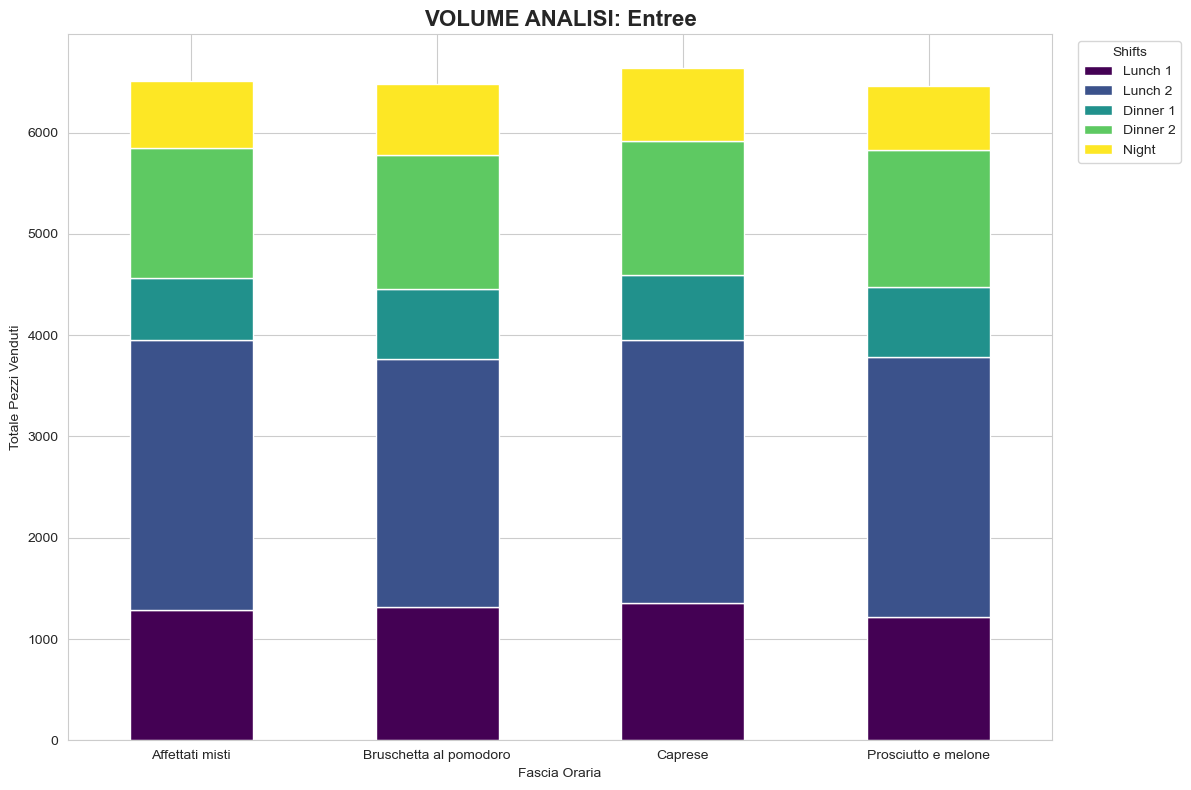

<Figure size 1600x1000 with 0 Axes>

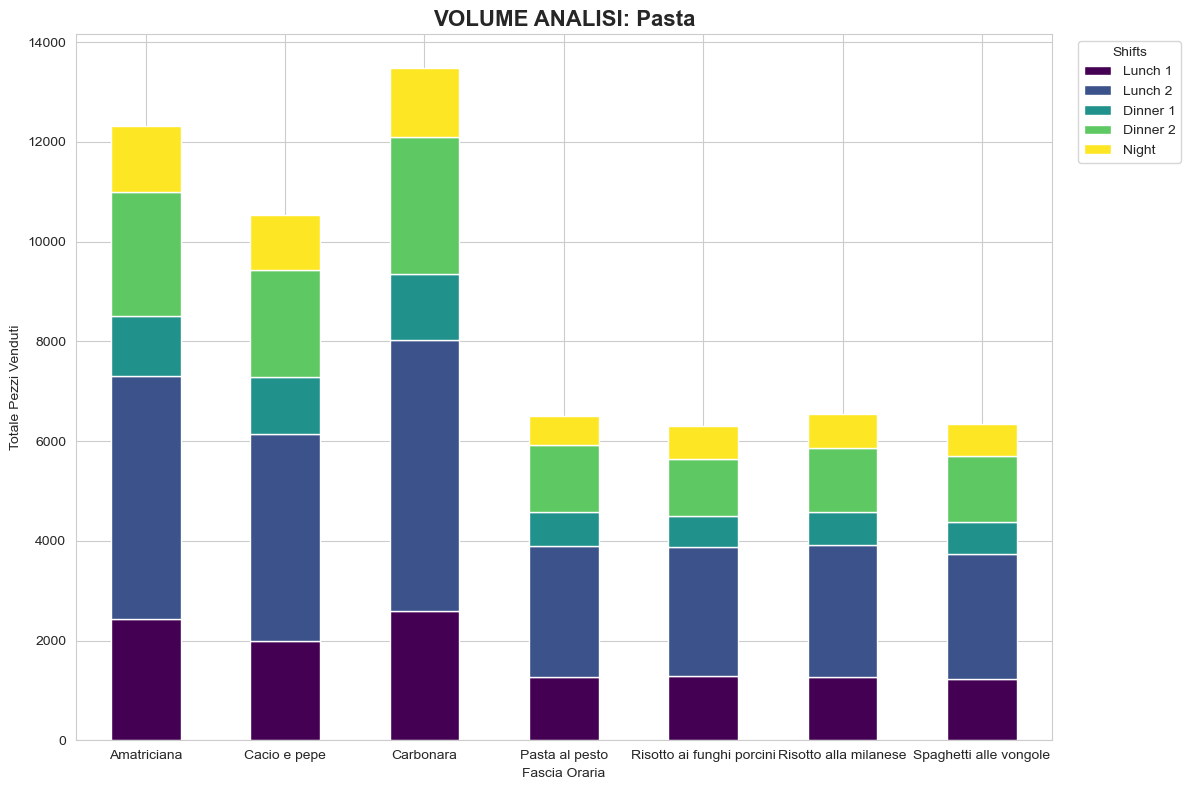

<Figure size 1600x1000 with 0 Axes>

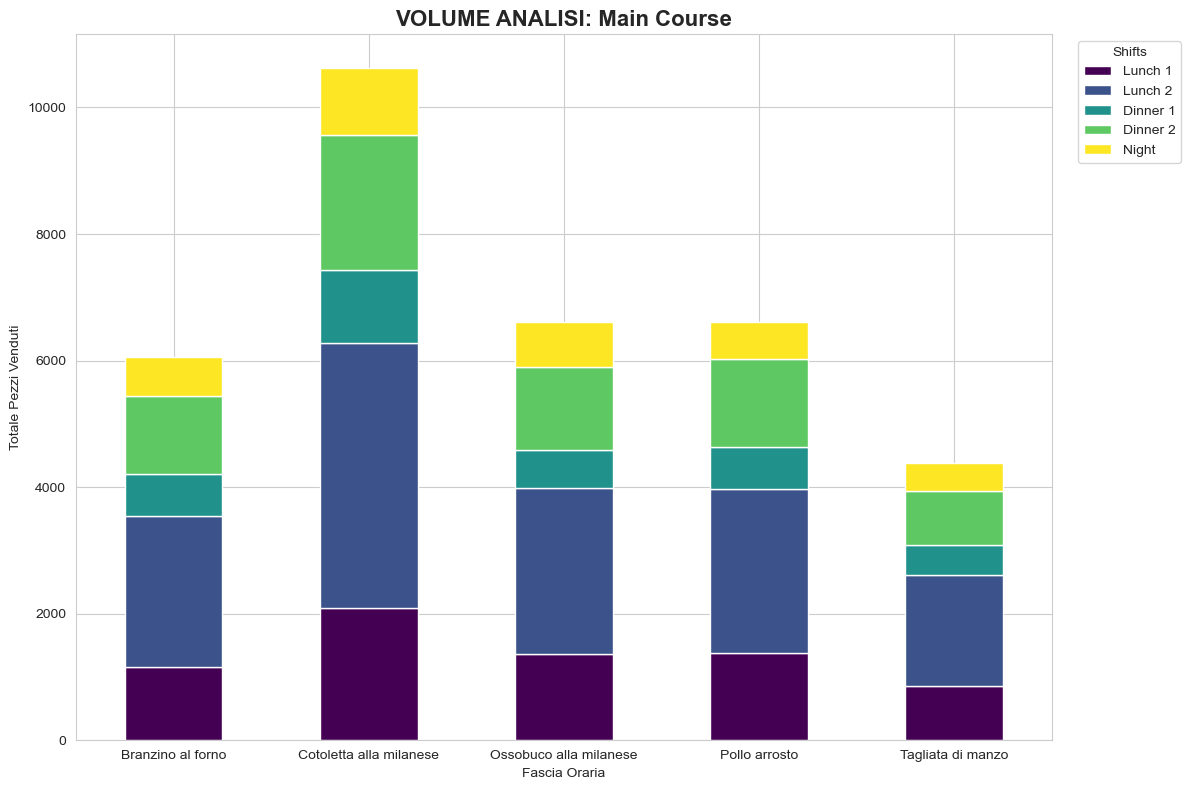

<Figure size 1600x1000 with 0 Axes>

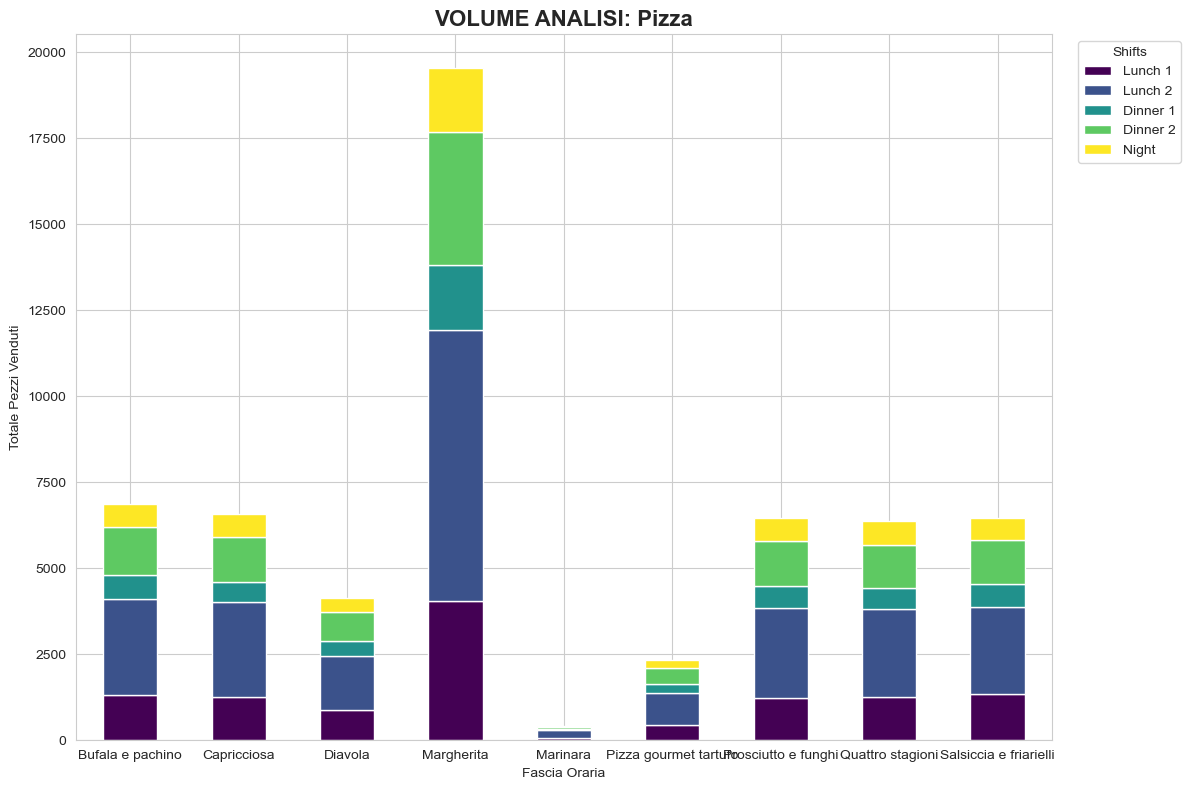

<Figure size 1600x1000 with 0 Axes>

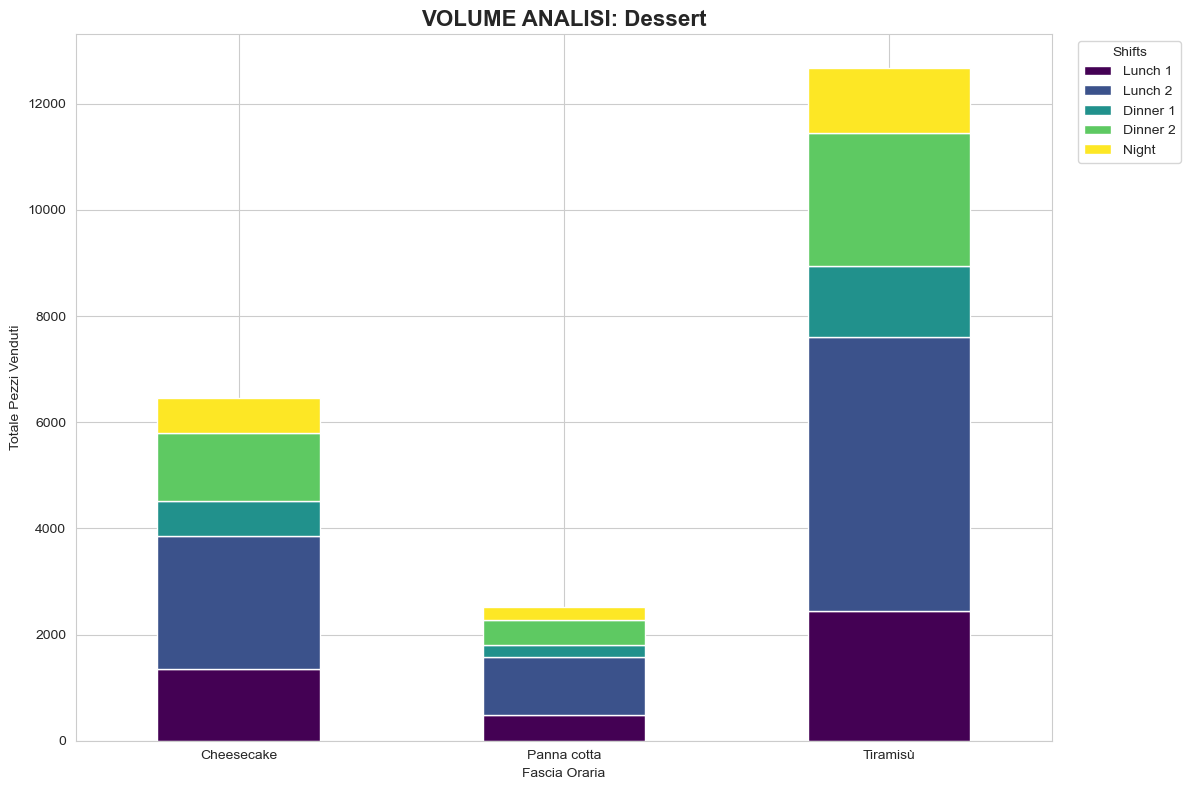

In [12]:
def plot_pivot(df, name):
    tables_shifts = ['Lunch 1', 'Lunch 2', 'Dinner 1', 'Dinner 2', 'Night']
    pivot = df.pivot_table(
    index=['item_name'], 
    columns='time_slot', 
    values='total_sold', 
    aggfunc='sum').fillna(0)
    pivot = pivot.reindex(columns=tables_shifts)
    # 4. VISUALIZZAZIONE
    plt.figure(figsize=(16, 10))
    ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
    plt.title(f'VOLUME ANALISI: {name}', fontsize=16, weight='bold')
    plt.xlabel('Fascia Oraria')
    plt.ylabel('Totale Pezzi Venduti')
    plt.xticks(rotation=0)
    plt.legend(title='Shifts', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for name, df in menu_dish.items():
    plot_pivot(df, name)

In [ ]:
# creazione heatmap per i 15 piatti più venduti
pivot['Total'] = pivot.sum(axis=1)
top_15 = pivot.sort_values('Total', ascending=False).drop(columns=['Total']).reset_index(level='item_id').head(15)

tables_shifts = ['Lunch 1', 'Lunch 2', 'Dinner 1', 'Dinner 2', 'Night']
top_15 = top_15.reindex(columns=tables_shifts).rename_axis('Time Slot', axis=1).rename_axis('Item Name', axis=0)
top_15

# -- 4. TOP 15 DISHES HEATMAP --
# heatmap for 15 most sold dishes
pivot['Total'] = pivot.sum(axis=1)
top_15 = pivot.sort_values('Total', ascending=False).drop(columns=['Total']).reset_index(level='item_id').head(15)

# Reordering columns for better visualization
tables_shifts = ['Lunch 1', 'Lunch 2', 'Dinner 1', 'Dinner 2', 'Night']
top_15 = top_15.reindex(columns=tables_shifts).rename_axis('Time Slot', axis=1).rename_axis('Item Name', axis=0)
top_15
plt.figure(figsize=(12, 8))
sns.heatmap(top_15, annot=True, fmt=".0f", cmap='YlGnBu', cbar=False) # cbar=False nasconde la barra dei colori per un look più pulito
plt.title('TOP 15 DISHES: VOLUME ANALYSIS BY TIME SLOT', fontsize=16, weight='bold')
plt.xlabel('') # Lasciamo vuoto per un look più pulito
plt.ylabel('') # Lasciamo vuoto per un look più pulito
plt.tick_params(axis='both', which='both', length=0) # Rimuove i tick per un look più pulito: axis='both' (x e y), which='both' (major/principali e minor/secondarie), length=0 (nessun tick)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

Time Slot,Lunch 1,Lunch 2,Dinner 1,Dinner 2,Night
Item Name,,,,,
Margherita,4059,7854,1899,3870,1857
Carbonara,2599,5423,1330,2752,1381
Tiramisù,2444,5160,1330,2510,1230
Amatriciana,2427,4874,1213,2492,1319
Cotoletta alla milanese,2085,4189,1163,2127,1060
Cacio e pepe,1990,4163,1128,2150,1105
Bufala e pachino,1311,2802,679,1412,653
Caprese,1352,2597,641,1332,717
Pollo arrosto,1372,2604,663,1394,573


### SEASONALITY

In [14]:
transactions

,transaction_id,store_id,item_id,channel,qty,total_net_price,time,date,item_name
0,TXN-000001,MIL-01,PIZ-002,Glovo,0.4,3.20,20:22:00,2024-01-01,Marinara
1,TXN-000002,MIL-01,BEV-005,Sala,7.0,10.50,13:52:00,2024-01-01,Caffè
2,TXN-000003,MIL-01,PRI-003,Deliveroo,3.0,42.90,21:54:00,2024-01-01,Cacio e pepe
3,TXN-000004,MIL-01,SEC-005,Take-away,2.0,32.00,20:51:00,2024-01-01,Pollo arrosto
4,TXN-000005,MIL-01,PIZ-007,Deliveroo,1.2,21.60,13:02:00,2024-01-01,Bufala e pachino
...,...,...,...,...,...,...,...,...,...
159912,TXN-159913,MIL-10,PRI-003,Sala,3.0,42.90,14:21:00,2024-12-31,Cacio e pepe
159913,TXN-159914,MIL-10,DOL-001,Sala,2.0,14.00,22:57:00,2024-12-31,Tiramisù
159914,TXN-159915,MIL-10,PRI-005,Sala,1.0,16.00,22:08:00,2024-12-31,Spaghetti alle vongole
159915,TXN-159916,MIL-10,PRI-003,Take-away,1.5,21.45,13:15:00,2024-12-31,Cacio e pepe


In [15]:
query = """select item_id, item_name, sum(qty) as total_sold, 
              case
                    when date >= '2024-04-01' and date <= '2024-06-30' then 'Spring'
                    when date >= '2024-07-01' and date <= '2024-09-30' then 'Summer'
                    when date >= '2024-10-01' and date <= '2024-12-31' then 'Autumn'
                    else 'Winter'
              end as seasons
          from transactions
          group by 1,2,4"""
seasons = ddb.query(query).to_df()
seasonal_stats = seasons.groupby(['item_id', 'item_name', 'seasons']).agg({'total_sold': 'sum'}).reset_index()
# il ~ (tilde) è equivalente al NOT
seasonal_stats = seasonal_stats[~seasonal_stats['item_id'].str.contains("BEV")]


entree_2 = seasonal_stats[seasonal_stats['item_id'].str.contains("ANT")].drop(columns=['item_id'])
pasta_2 = seasonal_stats[seasonal_stats['item_id'].str.contains("PRI")].drop(columns=['item_id'])
main_course_2 = seasonal_stats[seasonal_stats['item_id'].str.contains("SEC")].drop(columns=['item_id'])
dessert_2 = seasonal_stats[seasonal_stats['item_id'].str.contains("DOL")].drop(columns=['item_id'])
pizza_2 = seasonal_stats[seasonal_stats['item_id'].str.contains('PIZ')].drop(columns=['item_id'])

menu_dish_2 = {'Antipasti':entree_2, 'Pasta':pasta_2, 'Main': main_course_2, 'Pizza': pizza_2, 'Dessert': dessert_2}
display(menu_dish_2['Antipasti'])

,item_name,seasons,total_sold
0,Bruschetta al pomodoro,Autumn,1624.0
1,Bruschetta al pomodoro,Spring,1599.0
2,Bruschetta al pomodoro,Summer,1625.0
3,Bruschetta al pomodoro,Winter,1637.0
4,Caprese,Autumn,1687.0
5,Caprese,Spring,1692.0
6,Caprese,Summer,1617.0
7,Caprese,Winter,1643.0
8,Prosciutto e melone,Autumn,1603.0
9,Prosciutto e melone,Spring,1613.0


<Figure size 1600x1000 with 0 Axes>

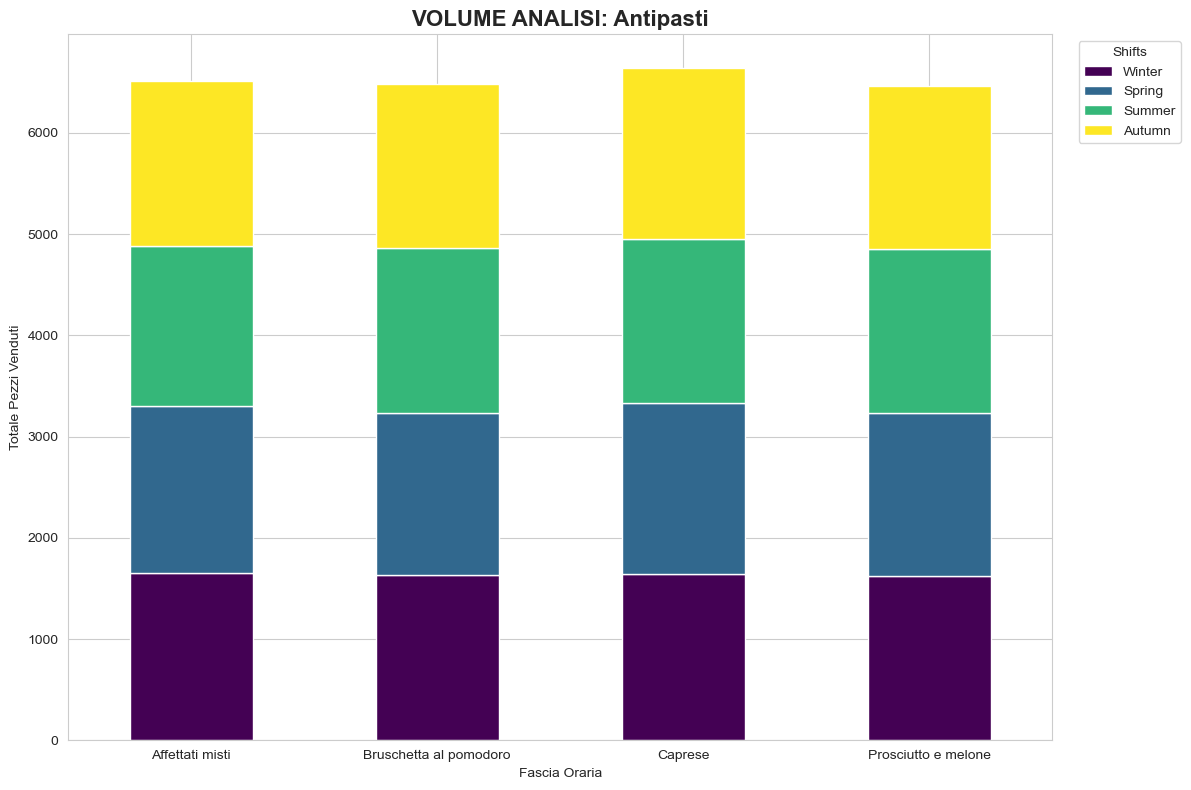

<Figure size 1600x1000 with 0 Axes>

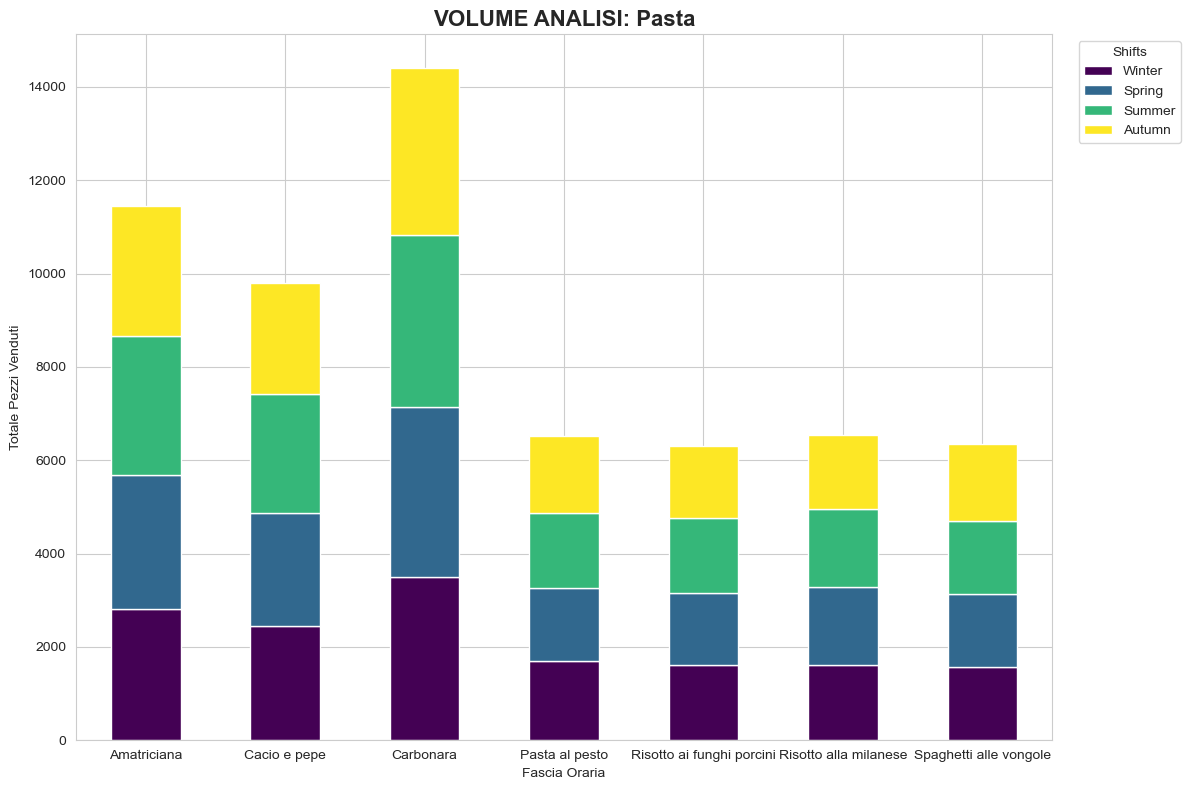

<Figure size 1600x1000 with 0 Axes>

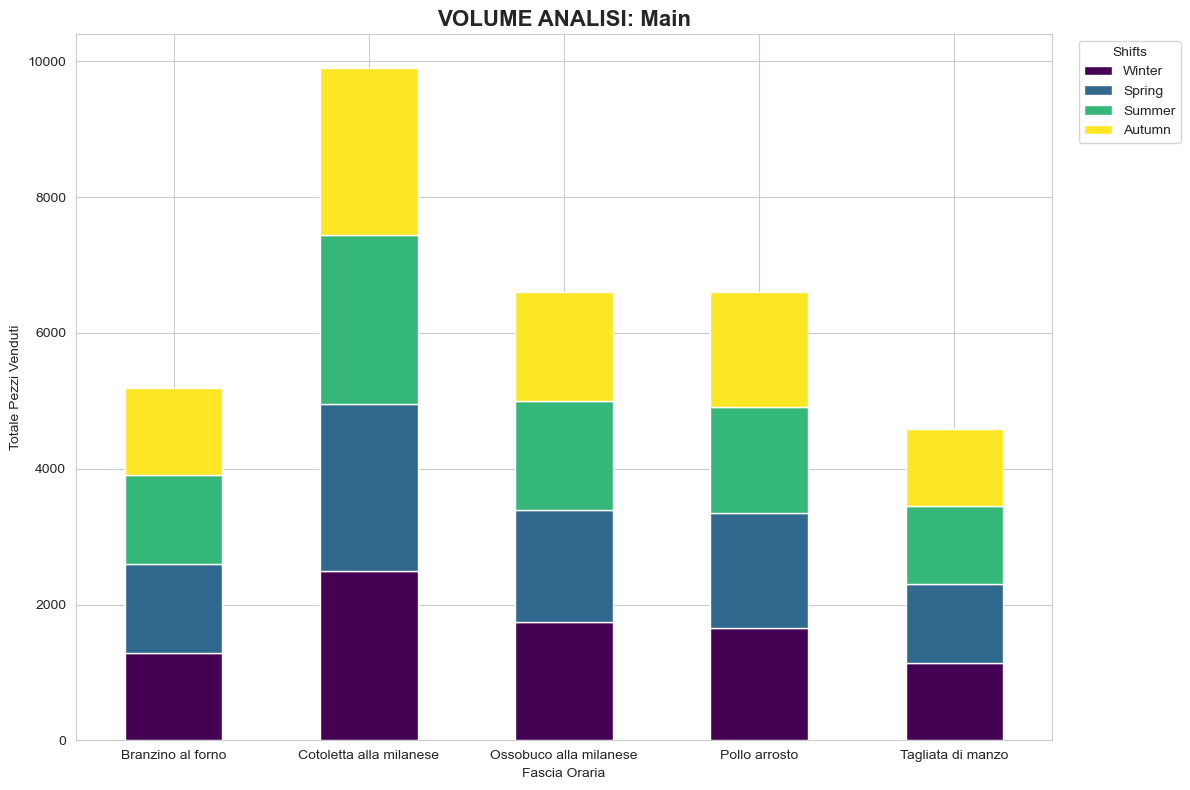

<Figure size 1600x1000 with 0 Axes>

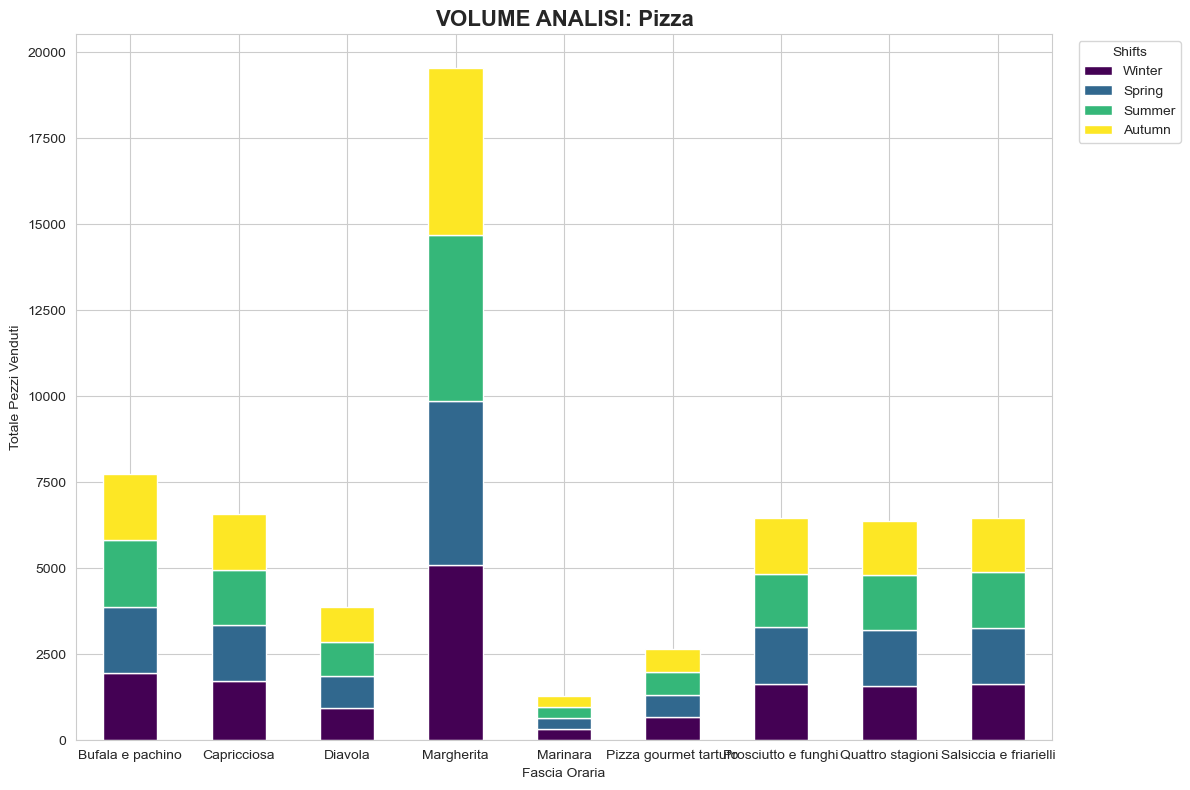

<Figure size 1600x1000 with 0 Axes>

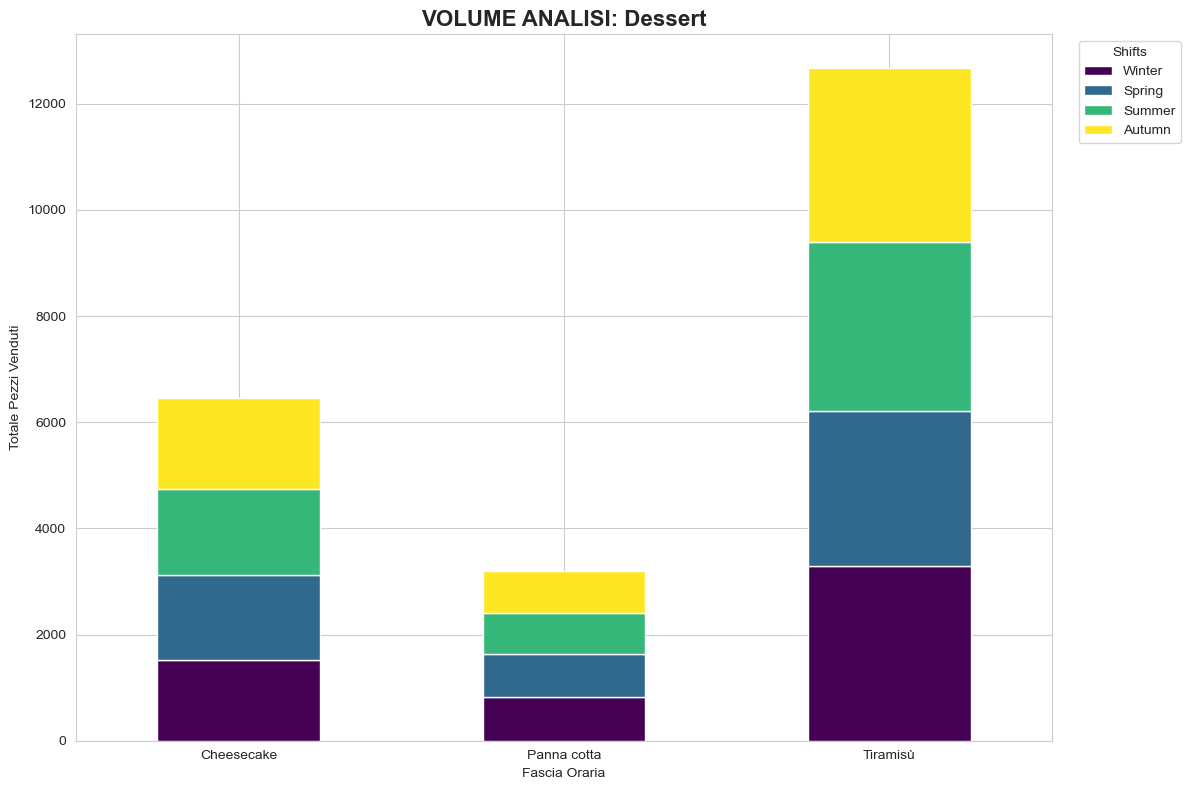

In [16]:
def plot_pivot(df, name):
    seasons_cols = ['Winter', 'Spring', 'Summer', 'Autumn']
    pivot = df.pivot_table(
    index=['item_name'], 
    columns='seasons', 
    values='total_sold', 
    aggfunc='sum').fillna(0)
    pivot = pivot.reindex(columns=seasons_cols)
    # 4. VISUALIZZAZIONE
    plt.figure(figsize=(16, 10))
    ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
    plt.title(f'VOLUME ANALISI: {name}', fontsize=16, weight='bold')
    plt.xlabel('Fascia Oraria')
    plt.ylabel('Totale Pezzi Venduti')
    plt.xticks(rotation=0)
    plt.legend(title='Shifts', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for name, df in menu_dish_2.items():
    plot_pivot(df, name)

### SALES FORECASTING

,qty
date,
2024-01-01,805.9
2024-01-02,700.5
2024-01-03,746.9
2024-01-04,847.5
2024-01-05,724.3


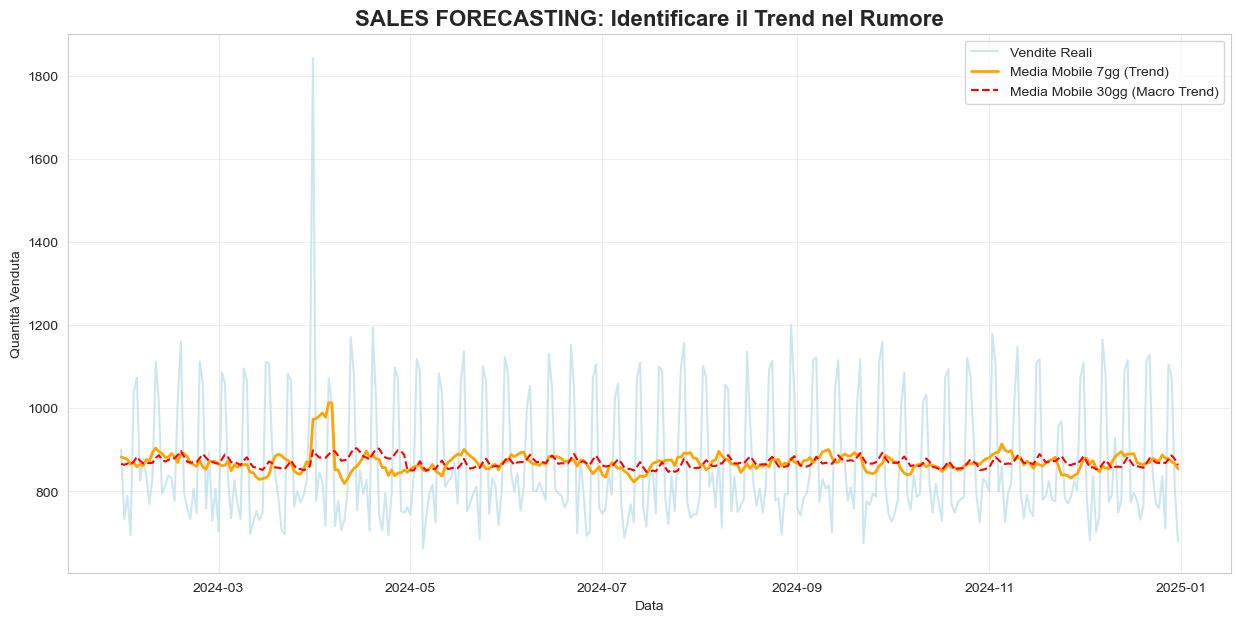

In [17]:
# 1. Aggregazione per Data
# Raggruppiamo tutte le transazioni per giorno per avere il flusso totale
daily_sales = transactions.groupby('date')['qty'].sum().reset_index()

# 2. Setup Indice Temporale
# Per le serie storiche, la data DEVE essere l'indice

daily_sales = daily_sales.set_index('date').sort_index()

# Controllo veloce
display(daily_sales.head())

# 3. Calcolo delle Medie Mobili
# window=7 significa: "Prendi oggi e i 6 giorni prima, e fai la media"
daily_sales['MA_7'] = daily_sales['qty'].rolling(window=7).mean()

# window=30 per il trend mensile
daily_sales['MA_30'] = daily_sales['qty'].rolling(window=30).mean()

# 4. Pulizia (i primi 7 giorni saranno NaN perché non hanno abbastanza storico)
daily_sales = daily_sales.dropna()

# 5. VISUALIZZAZIONE
plt.figure(figsize=(15, 7))

# A. Dati Reali (Rumorosi)
sns.lineplot(data=daily_sales, x=daily_sales.index, y='qty', label='Vendite Reali', color='lightblue', alpha=0.6)

# B. Trend Settimanale (La nostra previsione a breve)
sns.lineplot(data=daily_sales, x=daily_sales.index, y='MA_7', label='Media Mobile 7gg (Trend)', color='orange', linewidth=2)

# C. Trend Mensile (La direzione del business)
sns.lineplot(data=daily_sales, x=daily_sales.index, y='MA_30', label='Media Mobile 30gg (Macro Trend)', color='red', linestyle='--')

plt.title('SALES FORECASTING: Identificare il Trend nel Rumore', fontsize=16, weight='bold')
plt.xlabel('Data')
plt.ylabel('Quantità Venduta')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### **PERCHÈ LA MEDIA MOBILE**
Nel Revenue Management, il nostro nemico numero uno è il "rumore" (noise). I dati giornalieri di un ristorante sono incredibilmente rumorosi e fuorvianti se presi singolarmente.

1. Elimina il "Caso":

• Scenario: Ieri (Martedì) hai fatto 20 coperti. Martedì scorso ne hai fatti 50.

• Errore: Se guardi solo ieri, pensi "Crollo totale! Tagliamo il personale".

• Realtà: Magari ieri pioveva a dirotto o c'era la partita. La media mobile "spiana" questi eventi casuali e ti dice se c'è un vero problema strutturale o solo sfortuna.

2. Cattura la "Settimanalità" (Seasonality settimanale):

• Un ristorante vive di cicli di 7 giorni. Il Sabato non è mai paragonabile al Lunedì.

• Usando una Media Mobile a 7 giorni (Rolling 7D), includi nel calcolo esattamente un Lunedì, un Martedì... un Sabato e una Domenica.

• Questo "normalizza" il dato: ti permette di confrontare la performance di oggi con un valore che tiene conto del mix completo della settimana.

3. Rivela il Trend (La Direzione):

• I dati puntuali sono punti sparsi. La media mobile è una linea.

• Solo una linea ti può dire la direzione. Stai salendo verso l'alta stagione o stai scendendo? Questo è fondamentale per ordinare le scorte.

### **COME INTERPRETARE IL GRAFICO**
Quando guardi il grafico con le due linee (Dati Reali vs Media Mobile), ecco i 3 segnali da cercare:

1. **La Distanza (Spread) = Volatilità**
Guarda quanto i punti dei dati reali (blu) si allontanano dalla linea della media mobile (arancione).

• **Punti vicini alla linea:** Il tuo business è stabile e prevedibile. Puoi ottimizzare i turni al minuto.

• **Punti lontanissimi (Picchi e Valli):** Alta volatilità. Significa che il tuo locale dipende molto da fattori esterni (meteo, eventi).

**Azione:** Devi tenere più "scorta di sicurezza" (buffer stock) in magazzino e avere personale a chiamata (on-call), perché la previsione è difficile.

2. **L'Inclinazione (Slope) = Momentum**
Guarda la pendenza della linea della media mobile.

• **Inclinata verso l'alto:** La domanda sta crescendo strutturalmente.

**Azione:** È il momento di alzare leggermente i prezzi (Yield Management) o ridurre le promozioni.

• **Inclinata verso il basso:** La domanda si sta raffreddando.

**Azione:** Attiva promozioni per stimolare la domanda (es. "Vieni a cena martedì") e controlla severamente i costi del personale.

3. **Il "Lag" (Ritardo) = Attenzione**
Ricorda sempre che la media mobile "guarda indietro".

• Se oggi c'è un crollo improvviso, la media mobile ci metterà qualche giorno a scendere.

• Non usarla per reagire a un'emergenza istantanea (es. un lockdown improvviso), ma usala per pianificare la settimana successiva.

# QUARTO PILASTRO - OPERATIONS

### RevPASH

Analisi RevPASH avviata su 50 posti a sedere.


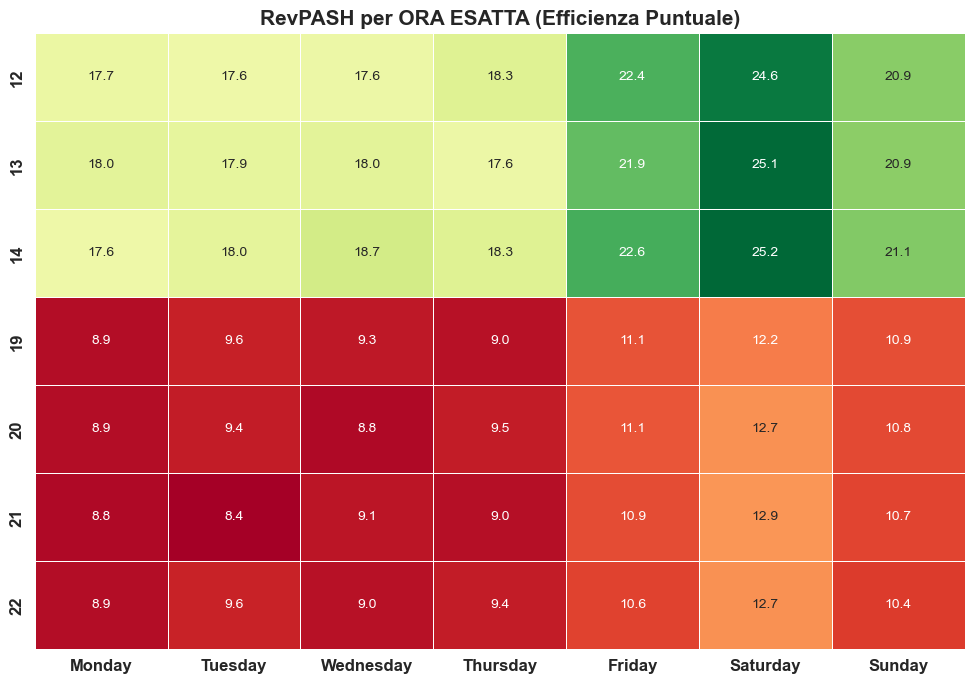

In [ ]:
# 1. --- CONFIGURAZIONE MANAGERIALE ---
SEATS = 50  # Capacità fissa
# Definiamo l'ordine dei giorni per i grafici
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Definiamo l'ordine degli slot
slots_order = ['Lunch 1', 'Lunch 2', 'Dinner 1', 'Dinner 2', 'Night']

# 2. --- PREPARAZIONE DATI ---
# Assicuriamoci di lavorare su una copia pulita
df_revpash = orders.copy()
df_revpash['timestamp'] = pd.to_datetime(df_revpash['timestamp'])
df_revpash['date'] = df_revpash['timestamp'].dt.date
df_revpash['weekday'] = df_revpash['timestamp'].dt.day_name()
df_revpash['hour'] = df_revpash['timestamp'].dt.hour

# consideriamo solo le transazioni in sala
df_revpash = df_revpash[df_revpash['channel'] == 'Sala']

print(f"Analisi RevPASH avviata su {SEATS} posti a sedere.")

# 1. Raggruppamento
# Calcoliamo: Fatturato Totale + Numero di giorni unici per quella combinazione Giorno/Ora
hourly_stats = df_revpash.groupby(['weekday', 'hour']).agg({
    'total_net_price': 'sum',
    'date': 'nunique' #  accopia ogni week_day alla data di riferimento, in modo da avere le statistiche corrette per ogni singolo giorno
}).reset_index()

# 2. Filtro Operativo (Business Rule #2)
# Teniamo solo le ore verosimili (es. 11:00 - 24:00) per pulire il grafico
hourly_stats = hourly_stats[hourly_stats['hour'].between(11, 23)]

# 3. Calcolo RevPASH
# Formula: Fatturato / (Giorni * Sedie * 1 ora)
hourly_stats['available_seat_hours'] = hourly_stats['date'] * SEATS
hourly_stats['RevPASH'] = hourly_stats['total_net_price'] / hourly_stats['available_seat_hours']

# 4. Visualizzazione Heatmap
pivot_hourly = hourly_stats.pivot(index='hour', columns='weekday', values='RevPASH')
pivot_hourly = pivot_hourly.reindex(columns=days_order) # Ordine Lun-Dom

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_hourly, cmap='RdYlGn', annot=True, fmt='.1f', linewidths=.5, cbar=False)
plt.title('RevPASH per ORA ESATTA (Efficienza Puntuale)', fontsize=15, weight='bold')
plt.xlabel('')
plt.xticks(fontsize=12, weight='bold')
plt.ylabel('')
plt.yticks(fontsize=12, weight='bold')
plt.show()


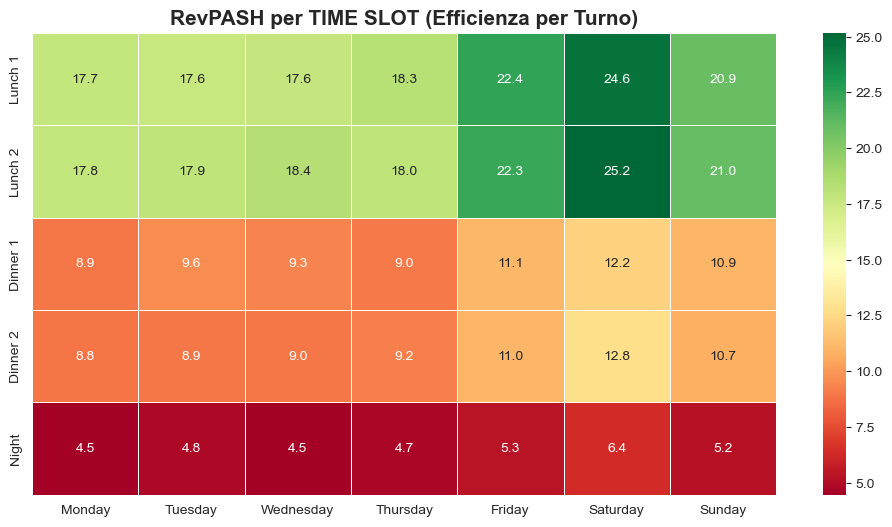

,transaction_id,timestamp,store_id,item_id,channel,qty,total_net_price,date,weekday,hour,time_slot
1,TXN-000002,2024-01-01 13:52:00,MIL-01,BEV-005,Sala,2,3.0,2024-01-01,Monday,13,Lunch 2
5,TXN-000006,2024-01-01 12:19:00,MIL-01,PIZ-001,Sala,2,18.0,2024-01-01,Monday,12,Lunch 1
7,TXN-000008,2024-01-01 12:25:00,MIL-01,PRI-003,Sala,1,13.0,2024-01-01,Monday,12,Lunch 1
8,TXN-000009,2024-01-01 20:46:00,MIL-01,BEV-004,Sala,2,5.0,2024-01-01,Monday,20,Dinner 2
9,TXN-000010,2024-01-01 13:53:00,MIL-01,PRI-005,Sala,1,16.0,2024-01-01,Monday,13,Lunch 2


In [48]:
# 3. -- REVPASH PER TIME SLOT ---
# 1. Definizione Slot Temporali (Business Rule #1)
# --- LOGICA DI MAPPING ---
# Questa funzione traduce un'ora numerica (es. 13) in un concetto di business (es. Lunch 2)
def assign_time_slot(h):
    if h == 11: return 'Morning'         # 11:00 - 11:59
    elif h == 12: return 'Lunch 1'       # 12:00 - 12:59
    elif h in [13, 14]: return 'Lunch 2' # 13:00 - 14:59
    elif h == 19: return 'Dinner 1'      # 19:00 - 19:59
    elif h in [20, 21]: return 'Dinner 2'# 20:00 - 21:59
    elif h >= 22: return 'Night'         # 22:00 in poi
    else: return 'Other'                 # Orari non operativi

# Applichiamo la logica riga per riga
df_revpash['time_slot'] = df_revpash['hour'].apply(assign_time_slot)

# Pulizia: teniamo solo gli slot operativi
df_revpash = df_revpash[~df_revpash['time_slot'].isin(['Other', 'Morning'])]

# consideriamo solo le transazioni in sala
df_revpash = df_revpash[df_revpash['channel'] == 'Sala']

# 2. Definizione Durata Slot (Business Rule #3)
# Mapping delle durate in ore (Stima basata sulla tua logica SQL precedente)
slot_durations = {
    'Morning': 1,   # Ipotizziamo 11-12
    'Lunch 1': 1,   # 12-13
    'Lunch 2': 2,   # 13-15
    'Dinner 1': 1,  # 19-20
    'Dinner 2': 2,  # 20-22
    'Night': 2      # 22-24
}


# 2. Raggruppamento per Slot
slot_stats = df_revpash.groupby(['weekday', 'time_slot']).agg({
    'total_net_price': 'sum',
    'date': 'nunique'
}).reset_index()

# 3. Calcolo Capacità Ponderata
# Aggiungiamo la durata dello slot al dataframe
slot_stats['duration'] = slot_stats['time_slot'].map(slot_durations).fillna(1) # Default 1h se manca

# Formula: Fatturato / (Giorni * Sedie * DURATA_SLOT)
slot_stats['available_seat_hours'] = slot_stats['date'] * SEATS * slot_stats['duration']
slot_stats['RevPASH_Slot'] = slot_stats['total_net_price'] / slot_stats['available_seat_hours']

# 4. Visualizzazione
pivot_slot = slot_stats.pivot(index='time_slot', columns='weekday', values='RevPASH_Slot')
pivot_slot = pivot_slot.reindex(index=slots_order, columns=days_order)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_slot, cmap='RdYlGn', annot=True, fmt='.1f', linewidths=.5)
plt.title('RevPASH per TIME SLOT (Efficienza per Turno)', fontsize=15, weight='bold')
plt.xlabel('')
plt.ylabel('')
plt.show()
display(df_revpash.head())

In [20]:
# script per variazione stagionale tavoli
# --- CONFIGURAZIONE AVANZATA ---
INDOOR_SEATS = 50
OUTDOOR_SEATS = 30

def get_capacity(row_date):
    """
    Restituisce la capacità corretta in base alla stagione.
    Dal 1 Maggio (Mese 5) al 30 Settembre (Mese 9) abbiamo il Dehors.
    """
    # Se il mese è tra Maggio (5) e Settembre (9) inclusi
    if 5 <= row_date.month <= 9:
        return INDOOR_SEATS + OUTDOOR_SEATS # 80 posti
    else:
        return INDOOR_SEATS # 50 posti

# --- APPLICAZIONE NEL CODICE ---
# Quando calcoli il denominatore, non usi più * SEATS, ma applichi la funzione
# Nota: row_date deve essere un oggetto datetime o date

# Esempio pratico su come cambia il calcolo nel dataframe:
# 1. Crei la colonna della capacità dinamica riga per riga
df_revpash['dynamic_seats'] = df_revpash['timestamp'].apply(get_capacity)

# 2. Usi quella colonna per il calcolo
# Formula: Fatturato / (Giorni * dynamic_seats * Ore)
# ... (il resto della logica rimane uguale, ma usi la colonna invece del numero fisso)

In [ ]:
# -- CHECK PER VEDERE SE LE TRANSAZIONI REGISTRATAE PER USCITA PIATTO O SOLO IN FASE DI PAGAMENTO --
# Controlliamo se ci sono timestamp diversi per lo stesso ordine
check_duration = df_revpash.groupby('transaction_id')['timestamp'].agg(['min', 'max'])
check_duration['duration_minutes'] = (check_duration['max'] - check_duration['min']).dt.total_seconds() / 60

# Se la media è 0, siamo nel caso B (Impossibile). Se > 0, siamo nel caso A (Fattibile).
print(f"Durata media ordine: {check_duration['duration_minutes'].mean()} minuti")

Durata media ordine: 0.0 minuti


### DATA AUGMENTATION - TABLE TURNOVER

In [49]:
# Lavoriamo su una copia per non sporcare l'originale
df_augmented = df_revpash.copy()

# --- 1. SIMULAZIONE CAMERIERI (Waitstaff) ---
# Creiamo 4 profili tipo
staff_list = ['Marco (Senior)', 'Sofia (Sommelier)', 'Luca (Junior)', 'Giulia (Part-time)']
# Probabilità: I Senior servono più tavoli dei Junior
staff_probs = [0.35, 0.25, 0.25, 0.15]

# Assegniamo un cameriere per ogni ORDER_ID (tutto il tavolo servito dallo stesso)
unique_orders = df_augmented['transaction_id'].unique()
assigned_staff = np.random.choice(staff_list, size=len(unique_orders), p=staff_probs)
# Mappatura Order_ID -> Cameriere
order_staff_map = dict(zip(unique_orders, assigned_staff))

df_augmented['waiter'] = df_augmented['transaction_id'].map(order_staff_map)


# --- 2. SIMULAZIONE DURATA TAVOLO (Turnover) ---
# La durata dipende da QUANDO mangi (A pranzo si corre, a cena si chiacchiera)
def simulate_duration(row):
    # Base: 45 minuti
    duration = 45 
    # Rumore casuale (+/- 15 min)
    duration += np.random.randint(-10, 20)
    
    # Se è Cena (Dinner 1/2), si sta di più (+30 min)
    if 'Dinner' in row['time_slot']:
        duration += 30 + np.random.randint(0, 30)
    # Se è Weekend, si sta di più (+15 min)
    if row['weekday'] in ['Friday', 'Saturday', 'Sunday']:
        duration += 15
        
    return duration

# Calcoliamo la durata simulata per ogni riga (in minuti)
df_augmented['table_duration_min'] = df_augmented.apply(lambda row: simulate_duration(row), axis=1)

print("Dataset potenziato!")
display(df_augmented[['timestamp', 'time_slot', 'waiter', 'table_duration_min']])

Dataset potenziato!


,timestamp,time_slot,waiter,table_duration_min
1,2024-01-01 13:52:00,Lunch 2,Sofia (Sommelier),56
5,2024-01-01 12:19:00,Lunch 1,Marco (Senior),62
7,2024-01-01 12:25:00,Lunch 1,Marco (Senior),61
8,2024-01-01 20:46:00,Dinner 2,Sofia (Sommelier),109
9,2024-01-01 13:53:00,Lunch 2,Luca (Junior),58
...,...,...,...,...
159911,2024-12-31 21:37:00,Dinner 2,Marco (Senior),90
159912,2024-12-31 14:21:00,Lunch 2,Marco (Senior),43
159913,2024-12-31 22:57:00,Night,Giulia (Part-time),35
159914,2024-12-31 22:08:00,Night,Luca (Junior),51


### TABLE TURNOVER